In [1]:
from relapse_prediction import constants, utils
from relapse_prediction.utils import binning
from relapse_prediction import features

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats
import pandas as pd
import numpy as np
import pickle


# 1. Correct IRM Features : 

## 1.1. Normalize the IRM features : 

In [2]:
def correct_irm_features(patient, imaging):
    
    path_irm_features = constants.dir_features / patient / f"{patient}_{imaging}_features.parquet"
    df_irm_imaging = pd.read_parquet(path_irm_features, engine="pyarrow")
    
    list_cols = [imaging, 'mean_5x5x5']
    
    for col in list_cols:
        df_irm_imaging[col] = stats.zscore(df_irm_imaging[col])
    
    df_irm_imaging.to_parquet(path_irm_features, engine="pyarrow")
    

In [3]:
for patient in tqdm(constants.list_patients):
    for imaging in constants.L_IRM_MAPS:
        correct_irm_features(patient, imaging)
        

  0%|          | 0/105 [00:00<?, ?it/s]

## 1.2. Binning the features : 

### 1.2.1. T1 IRM feature example : 

In [14]:
imaging, feature = "T1", "mean_5x5x5"

In [15]:
%%time
list_t1_features = utils.get_list_imaging_features(imaging, feature)

CPU times: total: 11.5 s
Wall time: 2min 7s


In [16]:
min_t1, max_t1 = min(list_t1_features), max(list_t1_features)

print("Minimum T1 intensity: ", min_t1)
print("Maximum T1 intensity: ", max_t1)

Minimum T1 intensity:  -5.051641647381908
Maximum T1 intensity:  12.069935094330173


In [20]:
rounded_min_t1 = np.round(min_t1, 2)
rounded_max_t1 = np.round(max_t1, 2)

print("Rounded Minimum T1 intensity: ", rounded_min_t1)
print("Runded Maximum T1 intensity: ", rounded_max_t1)

Rounded Minimum T1 intensity:  -5.05
Runded Maximum T1 intensity:  12.07


In [27]:
number_of_bins = int((rounded_max_t1 - rounded_min_t1) / 0.01)
print("Number of the number of bins: ", number_of_bins)

Number of the number of bins:  1712


<Axes: >

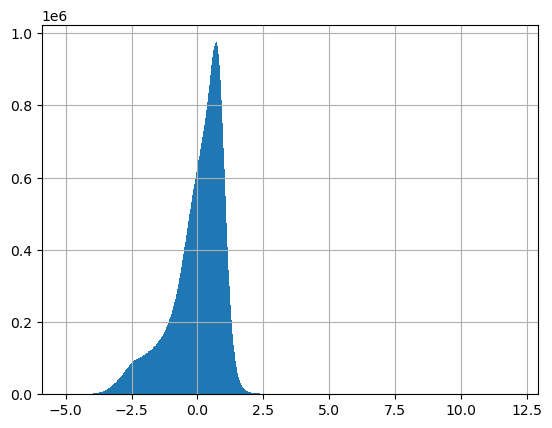

In [28]:
pd.Series(list_t1_features).hist(bins=1712)

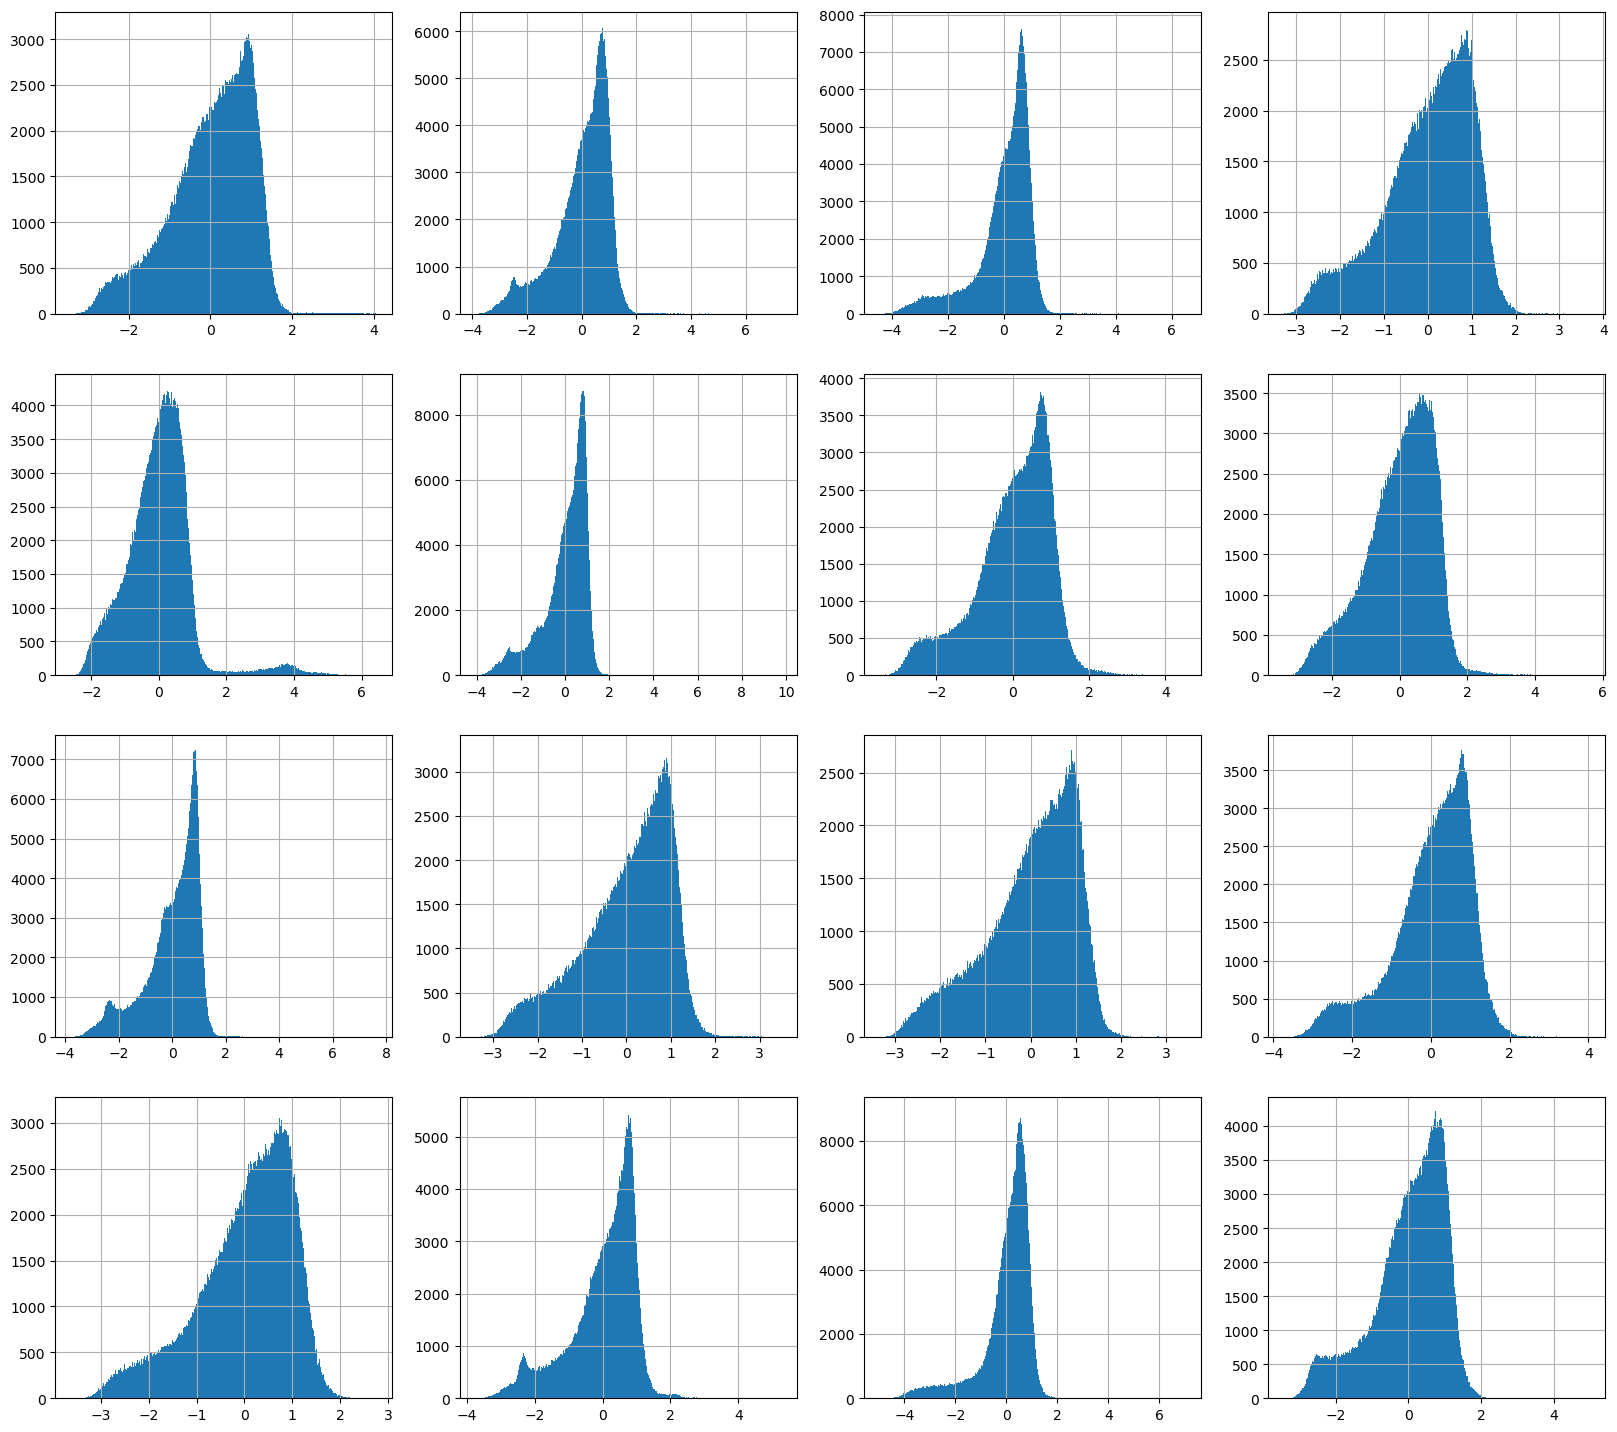

In [39]:
fig = plt.figure(figsize=(20, 18))

for i, patient in enumerate(constants.list_patients[:16]):

    fig.add_subplot(4, 4, i + 1)
    path_features = constants.dir_features / patient / fr"{patient}_{imaging}_features.parquet"
    df_features = pd.read_parquet(path_features, engine="pyarrow")
    df_features[feature].hist(bins=number_of_bins)

del df_features    
    

In [41]:
df_features = pd.read_parquet(path_features, engine="pyarrow")


In [44]:
np.round(df_features[feature], 2)

0         -2.83
1         -2.59
2         -2.48
3         -2.53
4         -2.69
           ... 
1655576   -2.79
1655577   -2.95
1655578   -2.87
1655579   -2.84
1655580   -2.85
Name: mean_5x5x5, Length: 1655581, dtype: float64

### 1.2.2. Binning MRI features :

In [4]:
def quantize_mri_features(patient, imaging):

    path_irm_features = constants.dir_features / patient / f"{patient}_{imaging}_features.parquet"
    df_irm_imaging = pd.read_parquet(path_irm_features, engine="pyarrow")
    
    list_cols = [imaging, 'mean_5x5x5']
    
    for col in list_cols:
        df_irm_imaging[col] = np.round(df_irm_imaging[col], 2)
    
    df_irm_imaging.to_parquet(path_irm_features, engine="pyarrow")


In [5]:
for patient in tqdm(constants.list_patients):
    for imaging in constants.L_IRM_MAPS:
        quantize_mri_features(patient, imaging)
        

  0%|          | 0/105 [00:00<?, ?it/s]

# 2. Correct CERCARE features : 

In [35]:
for imaging in constants.L_CERCARE_MAPS[::-1]:

    list_imaging = utils.get_list_imaging_features(imaging, imaging)
    min_feature, max_feature = min(list_imaging), max(list_imaging)

    p = - np.round(np.log10((max_feature - min_feature) / 1712))
    print(fr"imaging : {imaging}; p : {p}")




KeyboardInterrupt



In [33]:
def quantize_cercare_features(patient, imaging):

    path_features = constants.dir_features / patient / f"{patient}_{imaging}_features.parquet"
    df_imaging = pd.read_parquet(path_features, engine="pyarrow")



7.332708835601807

# 3. Correct the labels : 

In [6]:
def correct_labels(patient):
    
    path_labels = constants.dir_labels / f"{patient}_labels.parquet"
    
    df_labels = pd.read_parquet(path_labels, engine="pyarrow")
    
    list_cols = ['mean_L3R_5x5x5', 'mean_L3R - (L1 + L3)_5x5x5', 'mean_(L1 + L3)_5x5x5', 'mean_L2_5x5x5',   
                    'mean_L3_5x5x5', 'mean_L4_5x5x5', 'mean_L5_5x5x5', 'mean_(L4 + L5)_5x5x5']
    
    for col in list_cols:
        df_labels.loc[df_labels[col] < 0.5, col] = 0
        df_labels.loc[df_labels[col] >= 0.5, col] = 1
        
    dict_cols = {col: col.lstrip("mean_") for col in list_cols}
    
    df_labels = df_labels.rename(columns=dict_cols)
    
    df_labels.to_parquet(path_labels, engine="pyarrow")
    

In [7]:
for patient in tqdm(constants.list_patients):
    correct_labels(patient)
    

  0%|          | 0/105 [00:00<?, ?it/s]

KeyError: 'mean_L3R_5x5x5'

In [11]:
patient = "AIDREAM_1"
imaging = "T1CE"

path_labels = constants.dir_labels / f"{patient}_labels.parquet"
df_labels = pd.read_parquet(path_labels, engine="pyarrow")

path_features = constants.dir_features / patient / f"{patient}_{imaging}_features.parquet"
df_features = pd.read_parquet(path_features, engine="pyarrow")
df_features


,x,y,z,T1CE,mean_7x7,mean_5x5,mean_3x3,mean_3x3x3,mean_5x5x5
0,52.0,130.0,56.0,-2.45,-3.33,-3.06,-2.76,-2.15,-2.59
1,52.0,130.0,57.0,-2.36,-3.33,-3.06,-2.68,-2.17,-2.68
2,52.0,130.0,58.0,-2.33,-3.32,-3.07,-2.73,-2.29,-2.74
3,52.0,130.0,59.0,-2.39,-3.30,-3.07,-2.80,-2.43,-2.81
4,52.0,130.0,60.0,-2.37,-3.27,-3.06,-2.82,-2.54,-2.87
...,...,...,...,...,...,...,...,...,...
1447852,185.0,159.0,58.0,-2.12,-2.65,-2.51,-2.33,-1.33,-1.86
1447853,185.0,159.0,59.0,-2.19,-2.63,-2.45,-2.31,-1.34,-1.88
1447854,185.0,159.0,60.0,-2.40,-2.70,-2.55,-2.40,-1.50,-1.95
1447855,185.0,159.0,61.0,-2.62,-2.85,-2.79,-2.66,-1.78,-2.03


In [37]:
len(constants.list_patients)

104

In [ ]:
for patient in tqdm(list)